# Task 1 
## Algorithm:

1. Input an array of integers
2. Convert the integers and their respective indices to binary $\gets$ make sure that the numbers of bits for each integer is equal to the maximum number of binary digits used for the largest number. (Similarly for the indices)
3. Construct a list of quantum states where each quantum state is a tensor product of two quantum states:<br>
    a. the state formed from the index,<br>
    b. the state formed from the integer corresponding to that index
4. Construct superposition of the states in the above list.
5. Let $m$ be the number of bits used for storing indices and $n$ be the number of bits used for storing the integers.
6. Construct a projection operator using $n$ bits that projects onto those quantum states whose binary representation has alternating $0$s and $1$s.<br>
    N.B.: The projection operator will be formed from two matrices each of which are rank one matrices. These matrices are formed using the two possible states whose elements alternate in 0 and 1. A particular example of the projector matrix would be: $|0101...1\rangle\langle 0101...1| + |1010...0\rangle\langle 1010...0|$.
7. Apply this projection on the last $n$ qubits of the state constructed in step 4, and let's call the resultant state $|\chi\rangle$ such that $|\chi\rangle$ has the form<br> 
$$|\chi\rangle = |\psi\rangle|0101...1\rangle + |\phi\rangle|1010...0\rangle$$
   where $\langle\psi|\phi\rangle = 0$, and $|\psi\rangle$ and $|\phi\rangle$ contain the binary representation of the indices.
8. Next, on the last $n$ qubits, apply C-NOT by choosing any one qubit to be control (say for simplicity, the first one), and all others to be target. The state after this transformation is 
$$I_m\otimes CNOT_{a\to(b,n)}|\chi\rangle = (|\psi\rangle|0\rangle + |\phi\rangle|1\rangle)(|101...1\rangle)$$
9. Trace out the target $n-1$ qubits and project the control qubit onto the $|+\rangle$ state which is an equal superposition of $|0\rangle$ and $|1\rangle$. The state after normalization is
    $$\frac{1}{\sqrt{2}}(|\psi\rangle + |\phi\rangle)|+\rangle $$
10. Trace out the last qubit to get the desired result$$ \frac{1}{\sqrt{2}}(|\psi\rangle + |\phi\rangle)$$

### To execute the code:
1. Run the following two blocks of codes.
2. Now, define a variable of type Task_1 and initialize it with the list of integers (of any length) as follows:<br>
    For eg: c = Task_1([1,5,7,10])
3. The output will contain:<br>
    a. A histogram indicating the states of superpostion and their coefficient in the superposed state.<br>
    b. The state vector of the final quantum state. 

In [240]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute,Aer
from qiskit import quantum_info as qi
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import sys

In [241]:
class Task_1:
    """
    Class for creating a quantum state which is a superposition of the indices of the numbers from a given list such that
    these number's binary representation alternates in 0 and 1.
    Valid input: List of integers.
    Output: 1. A histogram indicating the states of superpostion and their coefficient in the superposed state.
            2. The state vector of the final quantum state.
    
    Variables and functions in this class:
    
    self.integer_list: List of input integers
    self.binary      : List of binary representation of the above integers
    self.index_binary: List of binary representation of the indices of the above integers
    
    self.qc          : List of quantum circuits. Each element is a quantum circuit pertaining to the preparation of a state 
                        which is a tensor product of the state formed from the index and the state formed from the binary 
                        representation of the number at that index
    self.q and self.c: List of quantum registers and classical registers used for the above Quantum Circuits
    
    Basic idea of the algorithm (step-wise):
    1. self.construct_state() : prepares a list of quantum states which encode the index along with the respective integer
                                from the provided list.
    2. self.construct_superposition() : prepares a state which is an equal superposition of the states prepared above.
                                        This is stored in self.superposed_vec. This is an object of Statevector class.
    3. self.construct_proj() : Constructs the projection operator pertaining to the desired result. The result is stored in
                               self.proj
    4. self.apply_proj() : This function applies the above projection operator to the state prepared in step 2. The resultant
                           state is an equal superposition of the desired states 
    5. self.evol() : This function further processes the resultant vector obtained from step 4. First this function gets rid
                     of all the qubits (except one) which contain the information of the binary representation of the special
                     numbers. We are now left with an entangled state whose first part is the index of the desired number and]
                     the second part is |0> or |1>. Then, this function projects the second part of this system onto the
                     maximally coherent state or the |+> state and traces it away. We are now left with the desired superposed
                     state.
    
    Other functions that I have added (although, the idea was to enhance the code even further by adding more such helper
    functions, but due to the deadline and other time constraints, I will submit the code as is for now leaving scope for
    adding more functions later):
    
    get_integers()    : Prints the list of integers
    get_binary()      : Prints the binary representation of integers
    get_index_binary(): Prints the indices of the integers.
    
    """
    def __init__(self, integer_list=[0,1]):
        if any(not isinstance(x, int) for x in integer_list):
            sys.exit("Numbers in the list are not all integers.")
            
        self.integer_list = integer_list
        self.binary = self.convert_to_bin(self.integer_list)
        self.index_binary = self.convert_to_bin(len(self.integer_list))
        
        self.qc = []
        self.q  = []
        self.c  = []
        
        self.construct_state()
        self.superposed_vec = self.construct_superposition()
        self.proj = self.construct_proj()
        self.vec_after_proj = self.apply_proj()
        self.evolved_vec = self.evol()
        print(self.evolved_vec)
       
    
    def convert_to_bin(self, list_or_num):
        binary_list=[]
        if isinstance(list_or_num, list):
            max_elem = max(list_or_num)
            self.total_dig = np.log2(max_elem)
            
            if abs(self.total_dig - int(self.total_dig))<1e-12:
                self.total_dig += 1
            else:
                self.total_dig = np.ceil(self.total_dig)
            self.total_dig = int(self.total_dig)
            
            for integer in list_or_num:
                if isinstance(integer,int):
                    binary_list.append(self.binary_(integer,self.total_dig))
                else:
                    sys.exit("the input list has elements which are not integers")
            return binary_list
        elif isinstance(list_or_num, int):
            self.index_total_dig = np.log2(list_or_num-1)
            if abs(self.index_total_dig - int(self.index_total_dig))<1e-12:
                self.index_total_dig += 1
            else:
                self.index_total_dig = np.ceil(self.index_total_dig)
            self.index_total_dig = int(self.index_total_dig)
            
            for integer_index in range(list_or_num):
                binary_list.append(self.binary_(integer_index, self.index_total_dig))
            return binary_list
        else:
            sys.exit("the input is not a list")
        
    def binary_(self, number, total_digits):
        return np.binary_repr(number, width=total_digits)
    
    def construct_state(self):
        
        num_qbits = self.index_total_dig + self.total_dig
        self.total_qubit_registers = num_qbits
        for i in range(len(self.integer_list)):
            self.q.append(QuantumRegister(num_qbits,"qreg"))
            self.qc.append(QuantumCircuit(self.q[i]))    
            new_string = self.index_binary[i] + self.binary[i]
            for j in range(num_qbits):
                if new_string[j] == '1':
                    self.qc[i].x(self.q[i][j])
    
    def construct_superposition(self):
        
        new_qc = QuantumCircuit(self.total_qubit_registers, 1)
        
        for i in range(self.total_qubit_registers):
            new_qc.h(i)
        superposed_state = Statevector(new_qc)
        
        proj_ = []
        index_proj = []
        for i in range(len(self.qc)):
            proj_.append(Statevector(self.qc[i]))
            proj_[i] = proj_[i].to_operator()
        for i in range(self.total_qubit_registers):
            index_proj.append(i)
            
        projector = proj_[0]
        if len(self.qc)>1:
            for i in range(1,len(self.qc)):
                projector += proj_[i]
        superposed_state = superposed_state.evolve(projector,index_proj)
        tr = superposed_state.trace()
        superposed_state  = superposed_state/np.sqrt(tr)
        return superposed_state
        
        
    def construct_proj(self):
        n = self.total_dig
        qc1 = QuantumCircuit(n)
        qc2 = QuantumCircuit(n)
        for i in range(n):
            if i%2 == 0:
                qc1.x(i)
            else:
                qc2.x(i)
        proj_1 = qi.Statevector(qc1)
        proj_2 = qi.Statevector(qc2)
        
        proj_1 = proj_1.to_operator()
        proj_2 = proj_2.to_operator()
        
        proj = proj_1+proj_2
        return proj
            
    def apply_proj(self):
        index_proj_list = []
        for i in range(self.total_qubit_registers-1,self.index_total_dig-1, -1):
            index_proj_list.append(i)
        
        new_qc_statevec = self.superposed_vec.evolve(self.proj,index_proj_list)
        
        temp_op = qi.DensityMatrix(new_qc_statevec)
        tr = temp_op.trace()
        if tr <= 1e-12:
            sys.exit("No number in the input whose binary structure is alternate")
            return
        temp_op = temp_op/tr
        new_qc_statevec = temp_op.to_statevector()
        
        return new_qc_statevec
    
    def evol(self):
        
        ### Create a quantum circuit and initialize it with the vector obtained after projection.
        
        qc_evol = QuantumCircuit(self.total_qubit_registers)
        qc_evol.initialize(self.vec_after_proj)
        
        ###############################################################################################################
        ###  Apply CNOT to the qubits that contain the binary representation of selected integers and              ####
        ###  leave the index part as it is. The control qubit can be chosen to any qubit. For simplicity, we have  ####
        ###  chosen the first qubit of the state containing the binary rep of selected integer from the list.      ####
        ###  See step 7 of algorithm given above.                                                                  ####
        ###############################################################################################################
        
        for i in range(self.index_total_dig+1, self.total_qubit_registers):
            qc_evol.cnot(self.index_total_dig, i)
        
        new_statevec = qi.Statevector(qc_evol)
        
        #####################################################
        ###  Project the control qubit to the plus state. ###
        ###  See step 9 of algorithm                      ###
        #####################################################
        qc2 = QuantumCircuit(1)
        qc2.h(0)
        plus_St = Statevector(qc2)
        plus_St = plus_St.to_operator()
        
        new_statevec = new_statevec.evolve(plus_St,[self.index_total_dig])
        
        partial_trace_index = []
        for j in range(self.index_total_dig, self.total_qubit_registers):
            partial_trace_index.append(j)
        
        
        if len(partial_trace_index)!=0:
            new_statevec = qi.partial_trace(new_statevec, partial_trace_index)
            tr = new_statevec.trace()
            new_statevec = (1/tr)*new_statevec

        new_statevec = new_statevec.to_statevector()
    
        qc_fin = QuantumCircuit(self.index_total_dig, self.index_total_dig)
        qc_fin.initialize(new_statevec)
        for i in range(int(np.floor(self.index_total_dig/2))):
            if i!=self.index_total_dig-1 -i:
                qc_fin.swap(i,self.index_total_dig-1 -i)
        
        qc_fin_ = qc_fin
        new_statevec = Statevector(qc_fin)
        
        #########################################################
        ######### Measurements to represent the counts ##########
        #########################################################
        for i in range(self.index_total_dig):
            qc_fin_.measure(i,i)

        job = execute(qc_fin_,Aer.get_backend('qasm_simulator'),shots=10000)
        counts = job.result().get_counts(qc_fin_)
        print(counts) # print the outcomes
 
        display(plot_histogram(counts))
    
        return new_statevec
    
    
    #######################################################################################
    ############################## Helper Functions #######################################
    ####################################################################################### 
    
    def get_integers(self):
        return self.integer_list
    
    def get_binary(self):
        #self.binary = self.convert_to_bin(self.integer_list)
        return self.binary
    
    def get_index_binary(self):
        #self.index_binary = self.convert_to_bin(len(self.integer_list))
        return self.index_binary
            
            

{'11': 4961, '01': 5039}


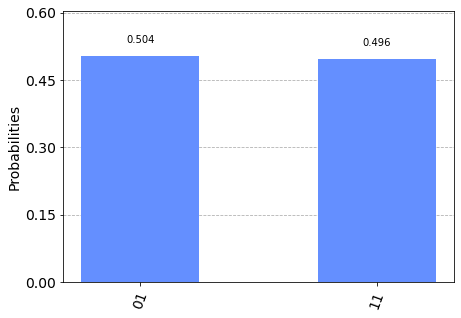

Statevector([6.12323400e-17+0.j, 7.07106781e-01+0.j, 1.73706117e-33+0.j,
             7.07106781e-01+0.j],
            dims=(2, 2))


In [242]:
c = Task_1([1,5,7,10])

{'011': 4995, '001': 5005}


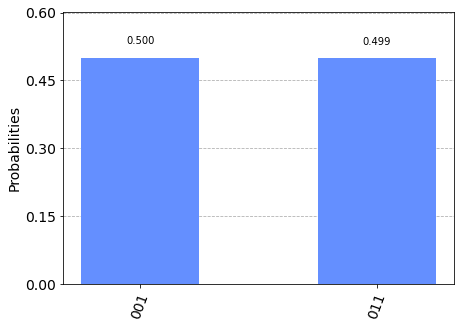

Statevector([ 6.12323400e-17+0.j,  7.07106781e-01+0.j, -1.80273746e-33+0.j,
              7.07106781e-01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
              0.00000000e+00+0.j,  0.00000000e+00+0.j],
            dims=(2, 2, 2))


In [243]:
d = Task_1([3,5,8,10,11,12])